In [1]:
import os, torch, random

# IMPORTANT: Fix for PyTorch/IPython compatibility issue
# This must run BEFORE importing torch to avoid decorator conflicts
# This fixes the "disable() got an unexpected keyword argument 'wrapping'" error

# Method 1: Try to disable dynamo via environment variable (needs to be set before import)
os.environ.setdefault('TORCH_COMPILE_DISABLE', '1')
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Method 2: Patch torch._dynamo.disable decorator after import
try:
    import torch._dynamo
    # Patch the disable function to ignore the 'wrapping' parameter
    if hasattr(torch._dynamo, 'disable'):
        def patched_disable(fn=None, *args, **kwargs):
            # Remove problematic 'wrapping' parameter if present
            if 'wrapping' in kwargs:
                kwargs.pop('wrapping')
            if fn is None:
                # Decorator usage: @disable
                return lambda f: f
            # Function usage: disable(fn) or disable(fn, **kwargs)
            # Simply return the function unwrapped to avoid recursion
            # The original disable was causing issues, so we bypass it entirely
            return fn
        torch._dynamo.disable = patched_disable
except Exception as e:
    print(f"Warning: Could not patch torch._dynamo: {e}")
    pass  # If patching fails, continue anyway

from torchtext import data
import numpy as np

os.environ['GENSIM_DATA_DIR'] = os.path.join(os.getcwd(), 'gensim-data')

import matplotlib.pyplot as plt

# import torch.nn as nn
# import torch.optim as optim
# from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
# from sklearn.preprocessing import label_binarize
from utils import *

In [2]:
SEED = 42
train_data, validation_data, test_data, LABEL, TEXT, pretrained_embed = data_prep(SEED)

[*] Prepping Data...
[+] Test set formed!
[+] Train and Validation sets formed!
[+] Data prepped successfully!
[*] Retrieving pretrained word embeddings...
[*] Loading fasttext model...
[+] Model loaded!
[*] Forming embedding matrix...
[+] Embedding matrix formed!
[+] Embeddings retrieved successfully!

Label distribution in training set:
- ABBR: 69 samples (1.58%)
- DESC: 930 samples (21.32%)
- ENTY: 1000 samples (22.93%)
- HUM: 978 samples (22.42%)
- LOC: 668 samples (15.31%)
- NUM: 717 samples (16.44%)
Total samples: 4362, Sum of percentages: 100.00%


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Build vocabulary for labels
LABEL.build_vocab(train_data)
num_classes = len(LABEL.vocab)
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {LABEL.vocab.itos}")

# Get pretrained embeddings from Part 1 (frozen embeddings)
pretrained_embeddings = pretrained_embed.weight.data

# Get embedding dimension and vocab size from the fasttext embedding layer
embedding_dim = pretrained_embed.weight.shape[1]
embedding_vocab_size = pretrained_embed.weight.shape[0]  # Vocab size from saved embedding


Number of classes: 6
Classes: ['ENTY', 'HUM', 'DESC', 'NUM', 'LOC', 'ABBR']


In [16]:
# ============================================================================
# Part 3.3: RNN + Attention Layer Model
# ============================================================================

print("\n" + "="*80)
print("PART 3.3: RNN + ATTENTION LAYER MODEL")
print("="*80)

class RNNWithAttentionClassifier(nn.Module):
    """
    RNN with Additive Attention Mechanism (Bahdanau-style)
    This is a more sophisticated attention mechanism than simple linear attention.
    Uses a feed-forward network to compute attention scores.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=2, dropout=0.5, padding_idx=0, pretrained_embeddings=None,
                 attention_dim=None):
        super(RNNWithAttentionClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.attention_dim = attention_dim if attention_dim else hidden_dim
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = True
        
        # Bidirectional LSTM layer (using LSTM for better performance)
        self.rnn = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,  # Bidirectional for better context
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Additive Attention Mechanism (Bahdanau-style)
        self.attention_linear1 = nn.Linear(hidden_dim * 2, self.attention_dim)  # *2 for bidirectional
        self.attention_linear2 = nn.Linear(self.attention_dim, 1)
        self.tanh = nn.Tanh()
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):        
        # Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # Pack sequences for efficient RNN processing
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # Pass through bidirectional LSTM
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # hidden: [n_layers * 2, batch_size, hidden_dim] (2 for bidirectional)
        
        # Unpack the sequences
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )
        
        # Step 1: Compute attention scores using feed-forward network
        attention_scores = self.attention_linear1(output)  # [batch_size, seq_len, attention_dim]
        attention_scores = self.tanh(attention_scores)  # Apply tanh activation
        attention_scores = self.attention_linear2(attention_scores).squeeze(2)  # [batch_size, seq_len]
        
        # Step 2: Mask padding positions
        batch_size, seq_len = output.size(0), output.size(1)
        mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths.unsqueeze(1)
        attention_scores = attention_scores.masked_fill(~mask, float('-inf'))
        
        # Step 3: Apply softmax to get attention weights
        attention_weights = torch.softmax(attention_scores, dim=1).unsqueeze(2)  # [batch_size, seq_len, 1]
        
        # Step 4: Compute weighted sum of RNN outputs
        context_vector = torch.sum(attention_weights * output, dim=1)  # [batch_size, hidden_dim * 2]
        
        # Apply dropout
        context_vector = self.dropout(context_vector)
        
        # Pass through fully connected layer
        output = self.fc(context_vector)  # [batch_size, output_dim]
        
        return output

print(">>> RNNWithAttentionClassifier model class created")
print("    - Uses bidirectional LSTM for encoding")
print("    - Implements additive attention mechanism (Bahdanau-style)")
print("    - More sophisticated than simple linear attention")


PART 3.3: RNN + ATTENTION LAYER MODEL
>>> RNNWithAttentionClassifier model class created
    - Uses bidirectional LSTM for encoding
    - Implements additive attention mechanism (Bahdanau-style)
    - More sophisticated than simple linear attention


In [17]:
# ============================================================================
# Train RNN + Attention Model
# ============================================================================

print("\n" + "="*80)
print("TRAINING RNN + ATTENTION MODEL")
print("="*80)

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameters (using similar settings to BiLSTM/BiGRU for fair comparison)
RNN_ATTN_HIDDEN_DIM = 256  # Effective hidden size will be 512 (256*2) due to bidirectional
RNN_ATTN_N_LAYERS = 2
RNN_ATTN_DROPOUT = 0.5
RNN_ATTN_BATCH_SIZE = 32
RNN_ATTN_LEARNING_RATE = 0.0001
RNN_ATTN_N_EPOCHS = 100
RNN_ATTN_PATIENCE = 10
RNN_ATTN_ATTENTION_DIM = 256  # Dimension for attention mechanism
RNN_ATTN_L1_LAMBDA = 1e-06
RNN_ATTN_L2_LAMBDA = 1e-05
RNN_ATTN_GRAD_CLIP = 0.0

# Create data iterators
train_iter_rnn_attn = data.BucketIterator(
    train_data,
    batch_size=RNN_ATTN_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter_rnn_attn = data.BucketIterator(
    validation_data,
    batch_size=RNN_ATTN_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter_rnn_attn = data.BucketIterator(
    test_data,
    batch_size=RNN_ATTN_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create RNN + Attention model
rnn_attn_model = RNNWithAttentionClassifier(
    vocab_size=embedding_vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=RNN_ATTN_HIDDEN_DIM,
    output_dim=num_classes,
    n_layers=RNN_ATTN_N_LAYERS,
    dropout=RNN_ATTN_DROPOUT,
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings,
    attention_dim=RNN_ATTN_ATTENTION_DIM
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
rnn_attn_optimizer = optim.RMSprop(rnn_attn_model.parameters(), lr=RNN_ATTN_LEARNING_RATE, weight_decay=RNN_ATTN_L2_LAMBDA)

print(f"\n>>> RNN + Attention Model Configuration:")
print(f"    Hidden Dim: {RNN_ATTN_HIDDEN_DIM} (effective: {RNN_ATTN_HIDDEN_DIM * 2} due to bidirectional)")
print(f"    Layers: {RNN_ATTN_N_LAYERS}")
print(f"    Dropout: {RNN_ATTN_DROPOUT}")
print(f"    Attention Dim: {RNN_ATTN_ATTENTION_DIM}")
print(f"    Learning Rate: {RNN_ATTN_LEARNING_RATE}")
print(f"    Batch Size: {RNN_ATTN_BATCH_SIZE}")
print(f"    Max Epochs: {RNN_ATTN_N_EPOCHS}, Patience: {RNN_ATTN_PATIENCE}")

# Train RNN + Attention model
rnn_attn_model, rnn_attn_history = train_model_with_history(
    rnn_attn_model, train_iter_rnn_attn, val_iter_rnn_attn, rnn_attn_optimizer, criterion,
    RNN_ATTN_N_EPOCHS, device, num_classes, RNN_ATTN_L1_LAMBDA, patience=RNN_ATTN_PATIENCE, model_name="RNN+Attention"
)

# Save best model
torch.save(rnn_attn_model.state_dict(), 'weights/rnn_attention_best.pt')
print(f"\n>>> RNN + Attention model saved to 'weights/rnn_attention_best.pt'")


TRAINING RNN + ATTENTION MODEL

>>> RNN + Attention Model Configuration:
    Hidden Dim: 256 (effective: 512 due to bidirectional)
    Layers: 2
    Dropout: 0.5
    Attention Dim: 256
    Learning Rate: 0.0001
    Batch Size: 32
    Max Epochs: 100, Patience: 10

>>> Training RNN+Attention
    Parameters: 5,282,007
    Max epochs: 100, Patience: 10
Epoch: 01/100 | Time: 0m 4s
	Train Loss: 1.7381 | Train Acc: 28.11%
	Val Loss: 1.4460 | Val Acc: 41.56% | Val F1: 0.3198 | Val AUC: 0.7719
Epoch: 02/100 | Time: 0m 4s
	Train Loss: 1.3106 | Train Acc: 51.63%
	Val Loss: 1.0467 | Val Acc: 57.52% | Val F1: 0.5383 | Val AUC: 0.8687
Epoch: 03/100 | Time: 0m 4s
	Train Loss: 1.0463 | Train Acc: 63.43%
	Val Loss: 0.9242 | Val Acc: 64.13% | Val F1: 0.6331 | Val AUC: 0.8899
Epoch: 04/100 | Time: 0m 4s
	Train Loss: 0.8808 | Train Acc: 71.96%
	Val Loss: 0.8261 | Val Acc: 69.36% | Val F1: 0.6918 | Val AUC: 0.9146
Epoch: 05/100 | Time: 0m 4s
	Train Loss: 0.7227 | Train Acc: 78.93%
	Val Loss: 0.8080 | Val

In [18]:
# ============================================================================
# Evaluate RNN + Attention Model on Test Set
# ============================================================================

print("\n" + "="*80)
print("TEST SET EVALUATION - RNN + ATTENTION")
print("="*80)

# Evaluate RNN + Attention
print("\n>>> Evaluating RNN + Attention on test set...")
rnn_attn_test_loss, rnn_attn_test_acc, rnn_attn_test_f1, rnn_attn_test_auc = evaluate_model(
    rnn_attn_model, test_iter_rnn_attn, criterion, device, "RNN+Attention", num_classes
)

print(f"\n>>> RNN + Attention Test Set Results:")
print(f"    Test Loss: {rnn_attn_test_loss:.4f}")
print(f"    Test Accuracy: {rnn_attn_test_acc*100:.2f}%")
print(f"    Test F1 Score: {rnn_attn_test_f1:.4f}")
print(f"    Test AUC-ROC: {rnn_attn_test_auc:.4f}")


TEST SET EVALUATION - RNN + ATTENTION

>>> Evaluating RNN + Attention on test set...

>>> RNN + Attention Test Set Results:
    Test Loss: 0.7852
    Test Accuracy: 78.40%
    Test F1 Score: 0.7977
    Test AUC-ROC: 0.9513


In [21]:
# ============================================================================
# Part 3.3: CNN + BiLSTM + Attention Model
# ============================================================================
# Hybrid model combining CNN, BiLSTM, and Attention mechanisms

print("\n" + "="*80)
print("PART 3.3: CNN + biLSTM + ATTENTION MODEL")
print("="*80)

class CNNBiLSTMAttentionClassifier(nn.Module):
    """
    Modified Hybrid model with label-specific representations:
    - CNN: Extracts n-gram features and produces label-specific latent representations
    - BiLSTM: Processes label-specific representations instead of full sentence
    - Attention: Focuses on relevant label-specific features
    """
    def __init__(self, vocab_size, embedding_dim, output_dim, 
                 num_filters=100, filter_sizes=[3, 4, 5],
                 hidden_dim=256, n_layers=2, dropout=0.5,
                 padding_idx=0, pretrained_embeddings=None,
                 attention_dim=None, label_latent_dim=None):
        super(CNNBiLSTMAttentionClassifier, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.attention_dim = attention_dim if attention_dim else hidden_dim
        self.label_latent_dim = label_latent_dim if label_latent_dim else hidden_dim
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = True
        
        # CNN layers to extract n-gram features
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=filter_size,
                padding=(filter_size - 1) // 2
            )
            for filter_size in filter_sizes
        ])
        
        # CNN produces label-specific latent representations
        cnn_output_dim = num_filters * len(filter_sizes)
        self.cnn_label_projections = nn.ModuleList([
            nn.Linear(cnn_output_dim, self.label_latent_dim)
            for _ in range(output_dim)
        ])
        
        # Dropout layers for regularization
        self.cnn_dropout = nn.Dropout(dropout)  # Dropout after CNN features
        self.bilstm_dropout = nn.Dropout(dropout)  # Dropout after BiLSTM outputs
        self.dropout = nn.Dropout(dropout)  # Dropout after attention
        
        # Bidirectional LSTM processes label-specific representations
        self.bilstm = nn.LSTM(
            self.label_latent_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Additive Attention Mechanism over label-specific BiLSTM outputs
        self.attention_linear1 = nn.Linear(hidden_dim * 2, self.attention_dim)  # *2 for bidirectional
        self.attention_linear2 = nn.Linear(self.attention_dim, 1)
        self.tanh = nn.Tanh()
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):        
        batch_size = text.size(0)
        
        # Step 1: Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # Step 2: Apply CNN to extract n-gram features
        embedded_cnn = embedded.permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]
        
        conv_outputs = []
        for conv in self.convs:
            conv_out = conv(embedded_cnn)
            conv_out = torch.relu(conv_out)
            conv_outputs.append(conv_out)
        
        # Ensure all conv outputs have the same sequence length
        min_seq_len = min(conv_out.size(2) for conv_out in conv_outputs)
        conv_outputs = [conv_out[:, :, :min_seq_len] for conv_out in conv_outputs]
        
        # Concatenate CNN features from all filter sizes
        cnn_features = torch.cat(conv_outputs, dim=1)
        
        # Step 3: Produce label-specific latent representations
        cnn_sentence_features = torch.max(cnn_features, dim=2)[0]  # [batch_size, cnn_output_dim]
        
        # Apply dropout to CNN features
        cnn_sentence_features = self.cnn_dropout(cnn_sentence_features)
        
        label_specific_reprs = []
        for label_proj in self.cnn_label_projections:
            label_repr = label_proj(cnn_sentence_features)  # [batch_size, label_latent_dim]
            label_specific_reprs.append(label_repr)
        
        # Stack label-specific representations to form a sequence
        # [batch_size, output_dim, label_latent_dim]
        label_sequence = torch.stack(label_specific_reprs, dim=1)
        
        # Step 4: Pass label-specific representations through BiLSTM
        label_lengths = torch.full((batch_size,), self.output_dim, dtype=torch.long, device=text.device)
        
        # Pack sequences for efficient processing
        packed_label_seq = nn.utils.rnn.pack_padded_sequence(
            label_sequence, label_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        packed_output, (hidden, cell) = self.bilstm(packed_label_seq)
        
        # Unpack sequences
        bilstm_output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )
        # bilstm_output: [batch_size, output_dim, hidden_dim * 2]
        
        # Apply dropout to BiLSTM outputs
        bilstm_output = self.bilstm_dropout(bilstm_output)
        
        # Step 5: Apply Attention Mechanism over label-specific BiLSTM outputs
        # Compute attention scores using feed-forward network
        attention_scores = self.attention_linear1(bilstm_output)  # [batch_size, output_dim, attention_dim]
        attention_scores = self.tanh(attention_scores)
        attention_scores = self.attention_linear2(attention_scores).squeeze(2)  # [batch_size, output_dim]
        
        # Apply softmax to get attention weights over label-specific representations
        attention_weights = torch.softmax(attention_scores, dim=1).unsqueeze(2)  # [batch_size, output_dim, 1]
        
        # Compute weighted sum of label-specific BiLSTM outputs
        context_vector = torch.sum(attention_weights * bilstm_output, dim=1)  # [batch_size, hidden_dim * 2]
        
        # Apply dropout
        context_vector = self.dropout(context_vector)
        
        # Step 6: Pass through fully connected layer
        output = self.fc(context_vector)  # [batch_size, output_dim]
        
        return output

print(">>> CNNBiLSTMAttentionClassifier model class created")
print("    - Combines CNN (n-gram features), BiLSTM (sequential dependencies), and Attention")
print("    - CNN extracts local patterns, BiLSTM captures long-range dependencies")
print("    - Attention mechanism focuses on important parts of the sequence")




PART 3.3: CNN + biLSTM + ATTENTION MODEL
>>> CNNBiLSTMAttentionClassifier model class created
    - Combines CNN (n-gram features), BiLSTM (sequential dependencies), and Attention
    - CNN extracts local patterns, BiLSTM captures long-range dependencies
    - Attention mechanism focuses on important parts of the sequence


In [25]:
# ============================================================================
# Train CNN + BiLSTM + Attention Model
# ============================================================================

print("\n" + "="*80)
print("TRAINING CNN + biLSTM + ATTENTION MODEL")
print("="*80)

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameters for CNN + BiLSTM + Attention
HYBRID_NUM_FILTERS = 100
HYBRID_FILTER_SIZES = [3, 4, 5]
HYBRID_HIDDEN_DIM = 256  # Effective hidden size will be 512 (256*2) due to bidirectional
HYBRID_N_LAYERS = 2
HYBRID_DROPOUT = 0.5
HYBRID_BATCH_SIZE = 32
HYBRID_LEARNING_RATE = 0.0001
HYBRID_N_EPOCHS = 100
HYBRID_PATIENCE = 10
HYBRID_ATTENTION_DIM = 256
HYBRID_L1_LAMBDA = 1e-06
HYBRID_L2_LAMBDA = 1e-05
HYBRID_GRAD_CLIP = 0.0

# Create data iterators
train_iter_hybrid = data.BucketIterator(
    train_data,
    batch_size=HYBRID_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter_hybrid = data.BucketIterator(
    validation_data,
    batch_size=HYBRID_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter_hybrid = data.BucketIterator(
    test_data,
    batch_size=HYBRID_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create CNN + BiLSTM + Attention model
hybrid_model = CNNBiLSTMAttentionClassifier(
    vocab_size=embedding_vocab_size,
    embedding_dim=embedding_dim,
    output_dim=num_classes,
    num_filters=HYBRID_NUM_FILTERS,
    filter_sizes=HYBRID_FILTER_SIZES,
    hidden_dim=HYBRID_HIDDEN_DIM,
    n_layers=HYBRID_N_LAYERS,
    dropout=HYBRID_DROPOUT,
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings,
    attention_dim=HYBRID_ATTENTION_DIM
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
hybrid_optimizer = optim.RMSprop(hybrid_model.parameters(), lr=HYBRID_LEARNING_RATE, weight_decay=HYBRID_L2_LAMBDA)

print(f"\n>>> CNN + BiLSTM + Attention Model Configuration:")
print(f"    CNN Filters: {HYBRID_NUM_FILTERS} per filter size")
print(f"    CNN Filter Sizes: {HYBRID_FILTER_SIZES}")
print(f"    BiLSTM Hidden Dim: {HYBRID_HIDDEN_DIM} (effective: {HYBRID_HIDDEN_DIM * 2} due to bidirectional)")
print(f"    BiLSTM Layers: {HYBRID_N_LAYERS}")
print(f"    Attention Dim: {HYBRID_ATTENTION_DIM}")
print(f"    Dropout: {HYBRID_DROPOUT}")
print(f"    Learning Rate: {HYBRID_LEARNING_RATE}")
print(f"    Batch Size: {HYBRID_BATCH_SIZE}")
print(f"    Max Epochs: {HYBRID_N_EPOCHS}, Patience: {HYBRID_PATIENCE}")

# Train hybrid model
hybrid_model, hybrid_history = train_model_with_history(
    hybrid_model, train_iter_hybrid, val_iter_hybrid, hybrid_optimizer, criterion,
    HYBRID_N_EPOCHS, device, num_classes, HYBRID_L1_LAMBDA, patience=HYBRID_PATIENCE, model_name="CNN+BiLSTM+Attention"
)

# Save best model
torch.save(hybrid_model.state_dict(), 'weights/cnn_bilstm_attention_best.pt')
print(f"\n>>> CNN + BiLSTM + Attention model saved to 'weights/cnn_bilstm_attention_best.pt'")


TRAINING CNN + biLSTM + ATTENTION MODEL

>>> CNN + BiLSTM + Attention Model Configuration:
    CNN Filters: 100 per filter size
    CNN Filter Sizes: [3, 4, 5]
    BiLSTM Hidden Dim: 256 (effective: 512 due to bidirectional)
    BiLSTM Layers: 2
    Attention Dim: 256
    Dropout: 0.5
    Learning Rate: 0.0001
    Batch Size: 32
    Max Epochs: 100, Patience: 10

>>> Training CNN+BiLSTM+Attention
    Parameters: 6,014,531
    Max epochs: 100, Patience: 10
Epoch: 01/100 | Time: 0m 4s
	Train Loss: 1.8016 | Train Acc: 22.90%
	Val Loss: 1.6345 | Val Acc: 24.13% | Val F1: 0.1431 | Val AUC: 0.6143
Epoch: 02/100 | Time: 0m 5s
	Train Loss: 1.6150 | Train Acc: 32.39%
	Val Loss: 1.2399 | Val Acc: 48.81% | Val F1: 0.4540 | Val AUC: 0.8150
Epoch: 03/100 | Time: 0m 5s
	Train Loss: 1.2596 | Train Acc: 50.94%
	Val Loss: 1.0273 | Val Acc: 57.25% | Val F1: 0.5509 | Val AUC: 0.8716
Epoch: 04/100 | Time: 0m 5s
	Train Loss: 1.0657 | Train Acc: 63.41%
	Val Loss: 0.8822 | Val Acc: 66.24% | Val F1: 0.6622 |

In [26]:
# ============================================================================
# Evaluate CNN + BiLSTM + Attention Model on Test Set
# ============================================================================

print("\n" + "="*80)
print("TEST SET EVALUATION - CNN + biLSTM + ATTENTION")
print("="*80)

# Evaluate hybrid model
print("\n>>> Evaluating CNN + BiLSTM + Attention on test set...")
hybrid_test_loss, hybrid_test_acc, hybrid_test_f1, hybrid_test_auc = evaluate_model(
    hybrid_model, test_iter_hybrid, criterion, device, "CNN+BiLSTM+Attention", num_classes
)

print(f"\n>>> CNN + BiLSTM + Attention Test Set Results:")
print(f"    Test Loss: {hybrid_test_loss:.4f}")
print(f"    Test Accuracy: {hybrid_test_acc*100:.2f}%")
print(f"    Test F1 Score: {hybrid_test_f1:.4f}")
print(f"    Test AUC-ROC: {hybrid_test_auc:.4f}")




TEST SET EVALUATION - CNN + biLSTM + ATTENTION

>>> Evaluating CNN + BiLSTM + Attention on test set...

>>> CNN + BiLSTM + Attention Test Set Results:
    Test Loss: 0.7856
    Test Accuracy: 85.20%
    Test F1 Score: 0.8512
    Test AUC-ROC: 0.9560


In [ ]:
from huggingface_hub import login
login("")

In [27]:
# ============================================================================
# Part 3.3: RNN + Pretrained BERT Model
# ============================================================================
# Hybrid model combining pretrained BERT embeddings with RNN

print("\n" + "="*80)
print("PART 3.3: RNN + PRETRAINED BERT MODEL")
print("="*80)

# Import transformers for BERT
try:
    from transformers import BertModel, BertTokenizer
    BERT_AVAILABLE = True
    print(">>> Transformers library available")
except ImportError:
    print(">>> Warning: transformers library not found. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers"])
    from transformers import BertModel, BertTokenizer
    BERT_AVAILABLE = True
    print(">>> Transformers library installed")

class RNNBertClassifier(nn.Module):
    """
    RNN with Pretrained BERT embeddings
    Uses BERT to get contextualized embeddings, then passes through BiLSTM with attention
    """
    def __init__(self, output_dim, hidden_dim=256, n_layers=2, dropout=0.5,
                 bert_model_name='distilbert-base-uncased', freeze_bert=False):
        super(RNNBertClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.freeze_bert = freeze_bert
        
        # Load pretrained BERT model and tokenizer
        self.bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
        self.bert_model = BertModel.from_pretrained(bert_model_name)
        
        # Freeze BERT parameters if specified
        if freeze_bert:
            for param in self.bert_model.parameters():
                param.requires_grad = False
        
        # BERT output dimension (768 for bert-base-uncased)
        bert_output_dim = self.bert_model.config.hidden_size
        
        # Bidirectional LSTM to process BERT embeddings
        self.bilstm = nn.LSTM(
            bert_output_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Additive Attention Mechanism (Bahdanau-style)
        self.attention_linear1 = nn.Linear(hidden_dim * 2, hidden_dim)  # *2 for bidirectional
        self.attention_linear2 = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text, text_lengths, text_vocab=None):        
        batch_size = text.size(0)
        seq_len = text.size(1)
        device = text.device
        
        # Convert token indices back to text strings using vocab
        text_list = []
        for i in range(batch_size):
            actual_len = text_lengths[i].item() if isinstance(text_lengths[i], torch.Tensor) else text_lengths[i]
            tokens = []
            for j in range(min(actual_len, seq_len)):
                token_idx = text[i, j].item()
                if text_vocab is not None and token_idx < len(text_vocab):
                    token = text_vocab[token_idx]
                    # Skip special tokens
                    if token not in ['<pad>', '<unk>', '<sos>', '<eos>']:
                        tokens.append(token)
                else:
                    # Fallback if vocab not provided
                    tokens.append(str(token_idx))
            # Join tokens to form sentence
            sentence = " ".join(tokens)
            text_list.append(sentence)
        
        # Tokenize with BERT
        encoded = self.bert_tokenizer(
            text_list,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        ).to(device)
        
        # Get BERT embeddings
        with torch.set_grad_enabled(not self.freeze_bert):
            bert_outputs = self.bert_model(**encoded)
            bert_embeddings = bert_outputs.last_hidden_state  # [batch_size, seq_len, 768]
        
        # Get actual sequence lengths from BERT tokenizer
        bert_lengths = encoded['attention_mask'].sum(dim=1).cpu()


        # Get BERT embeddings
        with torch.set_grad_enabled(not self.freeze_bert):
            bert_outputs = self.bert_model(**encoded)
            bert_embeddings = bert_outputs.last_hidden_state  # [batch_size, seq_len, 768]

        # Align lengths
        bert_lengths = encoded['attention_mask'].sum(dim=1)
        max_len = bert_embeddings.size(1)
        bert_lengths = bert_lengths.clamp(max=max_len).cpu()

        # Pack safely
        packed_bert = nn.utils.rnn.pack_padded_sequence(
        bert_embeddings, bert_lengths, batch_first=True, enforce_sorted=False
        )

        
        # Pack sequences for efficient RNN processing
        packed_bert = nn.utils.rnn.pack_padded_sequence(
            bert_embeddings, bert_lengths, batch_first=True, enforce_sorted=False
        )
        
        # Pass through bidirectional LSTM
        packed_output, (hidden, cell) = self.bilstm(packed_bert)
        
        # Unpack sequences
        bilstm_output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )
        # bilstm_output: [batch_size, seq_len, hidden_dim * 2]
        
        # Apply Attention Mechanism
        attention_scores = self.attention_linear1(bilstm_output)  # [batch_size, seq_len, hidden_dim]
        attention_scores = self.tanh(attention_scores)
        attention_scores = self.attention_linear2(attention_scores).squeeze(2)  # [batch_size, seq_len]
        
        # Mask padding positions
        batch_size_attn, seq_len_attn = bilstm_output.size(0), bilstm_output.size(1)
        mask = torch.arange(seq_len_attn, device=device).unsqueeze(0) < bert_lengths.unsqueeze(1).to(device)
        attention_scores = attention_scores.masked_fill(~mask, float('-inf'))
        
        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention_scores, dim=1).unsqueeze(2)  # [batch_size, seq_len, 1]
        
        # Compute weighted sum
        context_vector = torch.sum(attention_weights * bilstm_output, dim=1)  # [batch_size, hidden_dim * 2]
        
        # Apply dropout
        context_vector = self.dropout(context_vector)
        
        # Pass through fully connected layer
        output = self.fc(context_vector)  # [batch_size, output_dim]
        
        return output

print(">>> RNNBertClassifier model class created")
print("    - Uses pretrained BERT (bert-base-uncased) for contextualized embeddings")
print("    - Passes BERT embeddings through bidirectional LSTM")
print("    - Applies attention mechanism to focus on important parts")




PART 3.3: RNN + PRETRAINED BERT MODEL
>>> Transformers library available
>>> RNNBertClassifier model class created
    - Uses pretrained BERT (bert-base-uncased) for contextualized embeddings
    - Passes BERT embeddings through bidirectional LSTM
    - Applies attention mechanism to focus on important parts


In [ ]:
# ============================================================================
# Train RNN + BERT Model
# ============================================================================

print("\n" + "="*80)
print("TRAINING RNN + BERT MODEL")
print("="*80)

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameters for RNN + BERT
BERT_HIDDEN_DIM = 256  # Effective hidden size will be 512 (256*2) due to bidirectional
BERT_N_LAYERS = 2
BERT_DROPOUT = 0.5
BERT_BATCH_SIZE = 32  
BERT_LEARNING_RATE = 2e-5  # Lower learning rate for fine-tuning BERT
BERT_N_EPOCHS = 50  # Fewer epochs as BERT converges faster
BERT_PATIENCE = 7
BERT_FREEZE = False  # Fine-tune BERT (set to True to freeze BERT)
BERT_L1_LAMBDA = 1e-06
BERT_L2_LAMBDA = 1e-05
BERT_GRAD_CLIP = 0.0

# Create data iterators
train_iter_bert = data.BucketIterator(
    train_data,
    batch_size=BERT_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter_bert = data.BucketIterator(
    validation_data,
    batch_size=BERT_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter_bert = data.BucketIterator(
    test_data,
    batch_size=BERT_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create RNN + BERT model
bert_model = RNNBertClassifier(
    output_dim=num_classes,
    hidden_dim=BERT_HIDDEN_DIM,
    n_layers=BERT_N_LAYERS,
    dropout=BERT_DROPOUT,
    bert_model_name='bert-base-uncased',
    freeze_bert=BERT_FREEZE
).to(device)

# Loss function and optimizer
# Use different learning rates for BERT and other layers
bert_params = list(bert_model.bert_model.parameters())
other_params = [p for n, p in bert_model.named_parameters() if 'bert_model' not in n]

bert_optimizer = optim.RMSprop([
    {'params': bert_params, 'lr': BERT_LEARNING_RATE},
    {'params': other_params, 'lr': BERT_LEARNING_RATE * 10}  # Higher LR for new layers
], weight_decay=BERT_L2_LAMBDA)

print(f"\n>>> RNN + BERT Model Configuration:")
print(f"    BERT Model: bert-base-uncased")
print(f"    BERT Frozen: {BERT_FREEZE}")
print(f"    BiLSTM Hidden Dim: {BERT_HIDDEN_DIM} (effective: {BERT_HIDDEN_DIM * 2} due to bidirectional)")
print(f"    BiLSTM Layers: {BERT_N_LAYERS}")
print(f"    Dropout: {BERT_DROPOUT}")
print(f"    Learning Rate: {BERT_LEARNING_RATE} (BERT), {BERT_LEARNING_RATE * 10} (other layers)")
print(f"    Batch Size: {BERT_BATCH_SIZE}")
print(f"    Max Epochs: {BERT_N_EPOCHS}, Patience: {BERT_PATIENCE}")


# Train RNN + BERT model
bert_model, bert_history = train_model_with_history_bert(
    bert_model, train_iter_bert, val_iter_bert, bert_optimizer, criterion,
    BERT_N_EPOCHS, device, num_classes, BERT_L1_LAMBDA, patience=BERT_PATIENCE, model_name="RNN+BERT", 
    text_vocab=TEXT.vocab.itos
)

# Save best model
torch.save(bert_model.state_dict(), 'weights/rnn_bert_best.pt')
print(f"\n>>> RNN + BERT model saved to 'weights/rnn_bert_best.pt'")


TRAINING RNN + BERT MODEL

>>> RNN + BERT Model Configuration:
    BERT Model: bert-base-uncased
    BERT Frozen: False
    BiLSTM Hidden Dim: 256 (effective: 512 due to bidirectional)
    BiLSTM Layers: 2
    Dropout: 0.5
    Learning Rate: 2e-05 (BERT), 0.0002 (other layers)
    Batch Size: 32
    Max Epochs: 50, Patience: 7

>>> Training RNN+BERT
    Parameters: 113,295,111
    Max epochs: 50, Patience: 7
Epoch: 01/50 | Time: 0m 43s
	Train Loss: 4.0890 | Train Acc: 84.34%
	Val Loss: 0.2653 | Val Acc: 92.48% | Val F1: 0.9250 | Val AUC: 0.9876
Epoch: 02/50 | Time: 0m 43s
	Train Loss: 3.6997 | Train Acc: 96.17%
	Val Loss: 0.2656 | Val Acc: 93.85% | Val F1: 0.9391 | Val AUC: 0.9887
Epoch: 03/50 | Time: 0m 43s
	Train Loss: 3.5709 | Train Acc: 97.91%
	Val Loss: 0.3656 | Val Acc: 92.48% | Val F1: 0.9239 | Val AUC: 0.9850
Epoch: 04/50 | Time: 0m 43s
	Train Loss: 3.4708 | Train Acc: 98.78%
	Val Loss: 0.3121 | Val Acc: 93.67% | Val F1: 0.9371 | Val AUC: 0.9896
Epoch: 05/50 | Time: 0m 44s
	Tr

In [29]:
# ============================================================================
# Evaluate RNN + BERT Model on Test Set
# ============================================================================

print("\n" + "="*80)
print("TEST SET EVALUATION - RNN + BERT")
print("="*80)


# Evaluate RNN + BERT
print("\n>>> Evaluating RNN + BERT on test set...")
bert_test_loss, bert_test_acc, bert_test_f1, bert_test_auc = evaluate_model_bert(
    bert_model, test_iter_bert, criterion, device, "RNN+BERT", num_classes, text_vocab=TEXT.vocab.itos
)

print(f"\n>>> RNN + BERT Test Set Results:")
print(f"    Test Loss: {bert_test_loss:.4f}")
print(f"    Test Accuracy: {bert_test_acc*100:.2f}%")
print(f"    Test F1 Score: {bert_test_f1:.4f}")
print(f"    Test AUC-ROC: {bert_test_auc:.4f}")




TEST SET EVALUATION - RNN + BERT

>>> Evaluating RNN + BERT on test set...

>>> RNN + BERT Test Set Results:
    Test Loss: 0.4052
    Test Accuracy: 93.80%
    Test F1 Score: 0.9375
    Test AUC-ROC: 0.9794



PLOTTING TRAINING CURVES - RNN + ATTENTION
    Saved Part 3.3 curves to 'part3_3_training_curves.png'


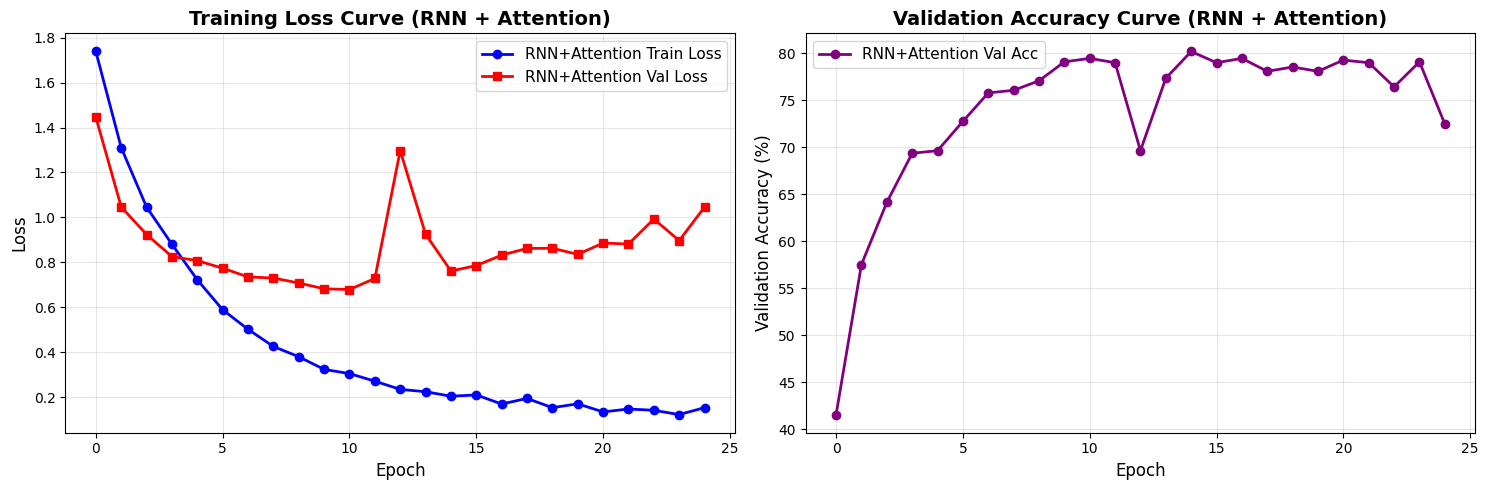


>>> Training curves plotted and saved for RNN + Attention model


In [30]:
# ============================================================================
# Plot Training Curves for RNN + Attention
# ============================================================================

print("\n" + "="*80)
print("PLOTTING TRAINING CURVES - RNN + ATTENTION")
print("="*80)

# Also create separate plots for Part 3.3 requirement (training loss and validation accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss Curve
ax1.plot(rnn_attn_history['train_losses'], label='RNN+Attention Train Loss', marker='o', linewidth=2, color='blue')
ax1.plot(rnn_attn_history['val_losses'], label='RNN+Attention Val Loss', marker='s', linewidth=2, color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss Curve (RNN + Attention)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation Accuracy Curve
ax2.plot([acc*100 for acc in rnn_attn_history['val_accs']], label='RNN+Attention Val Acc', marker='o', linewidth=2, color='purple')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve (RNN + Attention)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_3_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved Part 3.3 curves to 'part3_3_training_curves.png'")
plt.show()  # Display the plot in notebook

print("\n>>> Training curves plotted and saved for RNN + Attention model")


PLOTTING TRAINING CURVES - CNN + biLSTM + ATTENTION
    Saved Part 3.3 hybrid curves to 'part3_3_hybrid_training_curves.png'


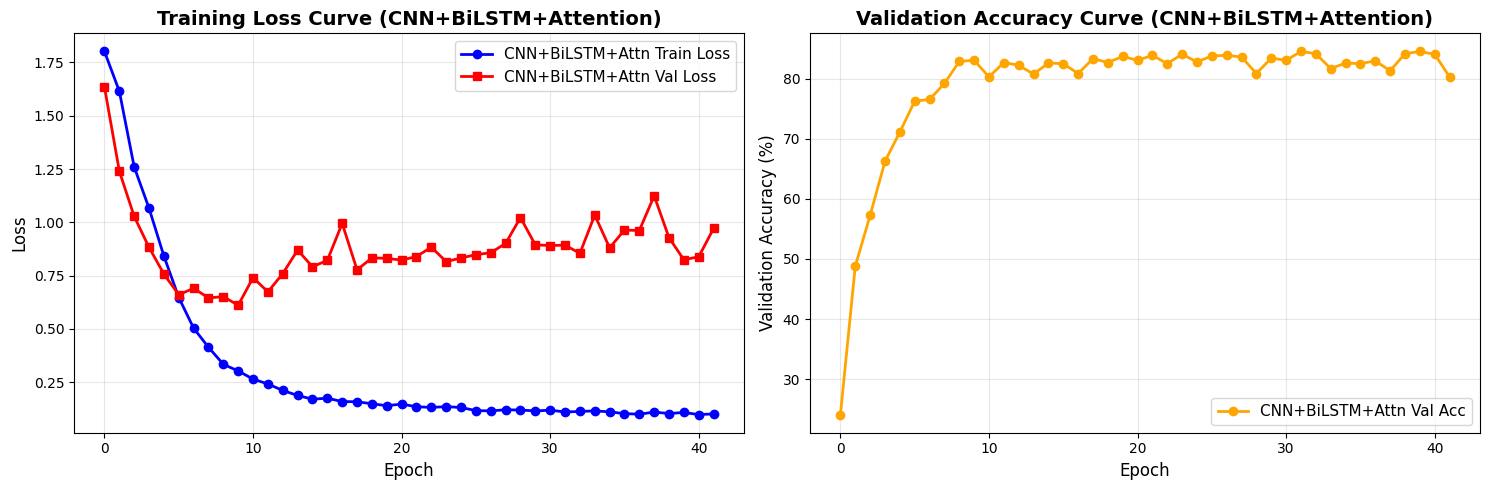


>>> Training curves plotted and saved for CNN + BiLSTM + Attention model


In [31]:
# ============================================================================
# Plot Training Curves for CNN + BiLSTM + Attention
# ============================================================================

print("\n" + "="*80)
print("PLOTTING TRAINING CURVES - CNN + biLSTM + ATTENTION")
print("="*80)

# Also create separate plots for Part 3.3 requirement (training loss and validation accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss Curve
ax1.plot(hybrid_history['train_losses'], label='CNN+BiLSTM+Attn Train Loss', marker='o', linewidth=2, color='blue')
ax1.plot(hybrid_history['val_losses'], label='CNN+BiLSTM+Attn Val Loss', marker='s', linewidth=2, color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss Curve (CNN+BiLSTM+Attention)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation Accuracy Curve
ax2.plot([acc*100 for acc in hybrid_history['val_accs']], label='CNN+BiLSTM+Attn Val Acc', marker='o', linewidth=2, color='orange')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve (CNN+BiLSTM+Attention)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_3_hybrid_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved Part 3.3 hybrid curves to 'part3_3_hybrid_training_curves.png'")
plt.show()  # Display the plot in notebook

print("\n>>> Training curves plotted and saved for CNN + BiLSTM + Attention model")




PLOTTING TRAINING CURVES - RNN + BERT
    Saved Part 3.3 BERT curves to 'part3_3_bert_training_curves.png'


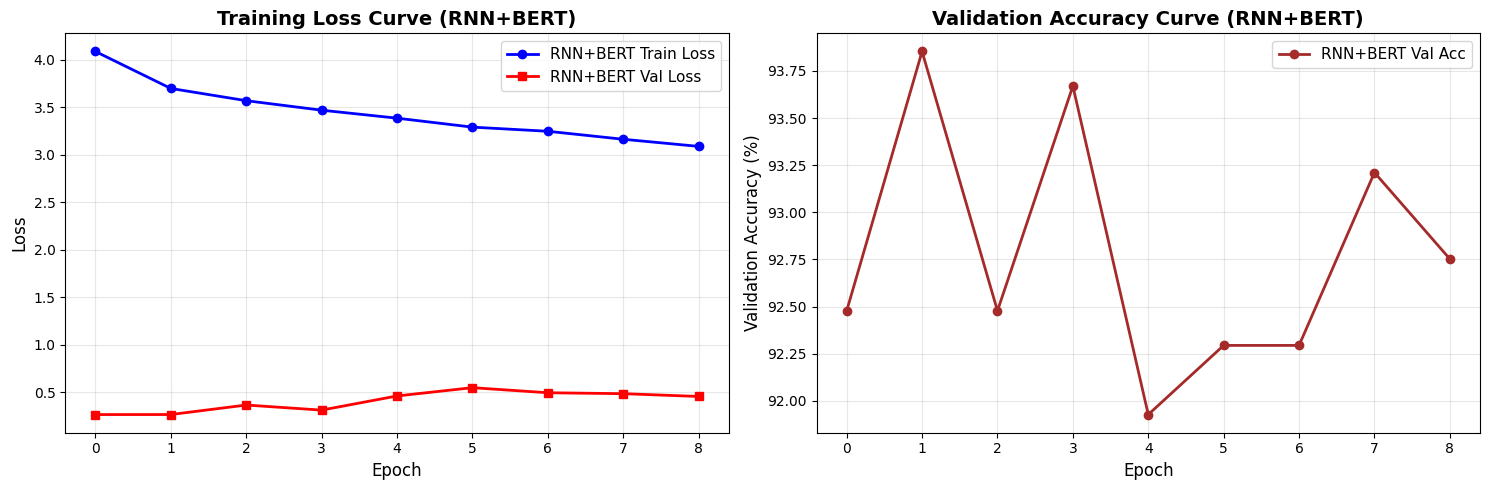


>>> Training curves plotted and saved for RNN + BERT model


In [32]:
# ============================================================================
# Plot Training Curves for RNN + BERT
# ============================================================================

print("\n" + "="*80)
print("PLOTTING TRAINING CURVES - RNN + BERT")
print("="*80)

# Also create separate plots for Part 3.3 requirement (training loss and validation accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss Curve
ax1.plot(bert_history['train_losses'], label='RNN+BERT Train Loss', marker='o', linewidth=2, color='blue')
ax1.plot(bert_history['val_losses'], label='RNN+BERT Val Loss', marker='s', linewidth=2, color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss Curve (RNN+BERT)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation Accuracy Curve
ax2.plot([acc*100 for acc in bert_history['val_accs']], label='RNN+BERT Val Acc', marker='o', linewidth=2, color='brown')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve (RNN+BERT)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_3_bert_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved Part 3.3 BERT curves to 'part3_3_bert_training_curves.png'")
plt.show()  # Display the plot in notebook

print("\n>>> Training curves plotted and saved for RNN + BERT model")


PLOTTING TRAINING CURVES
    Saved training curves to 'part3_3_all_models_training_curves.png'


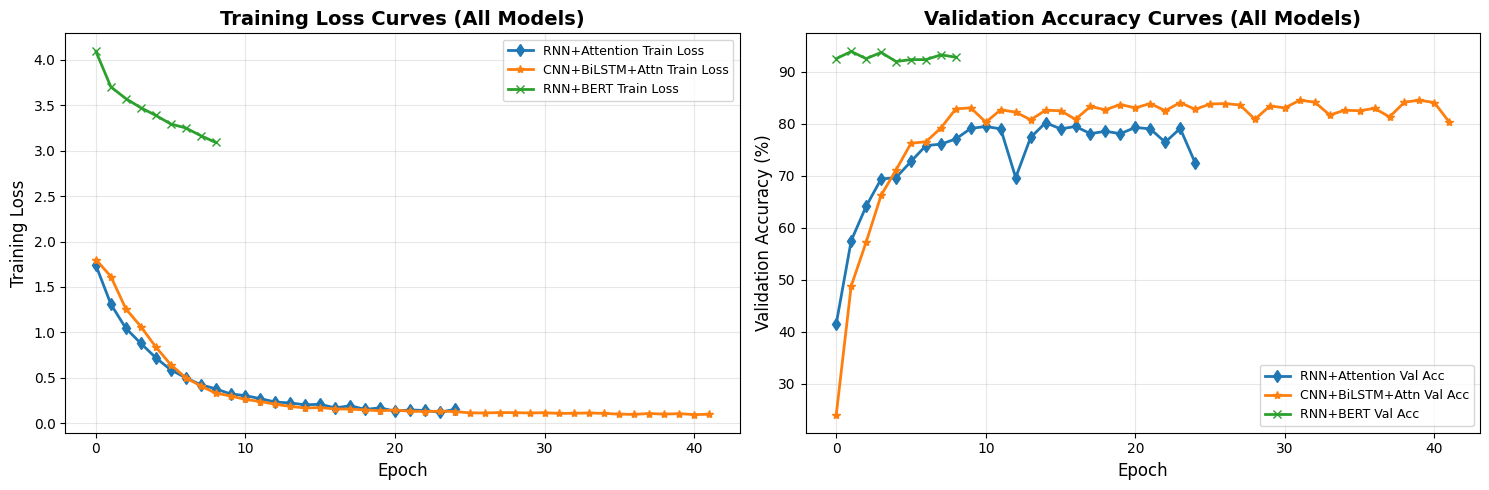

In [33]:
# ============================================================================
# Plot Training Curves for Strategies Used
# ============================================================================

print("\n" + "="*80)
print("PLOTTING TRAINING CURVES")
print("="*80)

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss Curves (All Models)
# axes[0].plot(bilstm_history['train_losses'], label='biLSTM Train Loss', marker='o', linewidth=2)
# axes[0].plot(bigru_history['train_losses'], label='biGRU Train Loss', marker='s', linewidth=2)
# axes[0].plot(cnn_history['train_losses'], label='CNN Train Loss', marker='^', linewidth=2)
axes[0].plot(rnn_attn_history['train_losses'], label='RNN+Attention Train Loss', marker='d', linewidth=2)
axes[0].plot(hybrid_history['train_losses'], label='CNN+BiLSTM+Attn Train Loss', marker='*', linewidth=2)
axes[0].plot(bert_history['train_losses'], label='RNN+BERT Train Loss', marker='x', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Training Loss Curves (All Models)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy Curves (All Models)
# axes[1].plot([acc*100 for acc in bilstm_history['val_accs']], label='biLSTM Val Acc', marker='o', linewidth=2)
# axes[1].plot([acc*100 for acc in bigru_history['val_accs']], label='biGRU Val Acc', marker='s', linewidth=2)
# axes[1].plot([acc*100 for acc in cnn_history['val_accs']], label='CNN Val Acc', marker='^', linewidth=2)
axes[1].plot([acc*100 for acc in rnn_attn_history['val_accs']], label='RNN+Attention Val Acc', marker='d', linewidth=2)
axes[1].plot([acc*100 for acc in hybrid_history['val_accs']], label='CNN+BiLSTM+Attn Val Acc', marker='*', linewidth=2)
axes[1].plot([acc*100 for acc in bert_history['val_accs']], label='RNN+BERT Val Acc', marker='x', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[1].set_title('Validation Accuracy Curves (All Models)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.savefig('part3_3_all_models_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved training curves to 'part3_3_all_models_training_curves.png'")
plt.show()  # Display the plot in notebook

In [34]:
# ============================================================================
# Part 3.3 Final Summary - All Models Including RNN + BERT
# ============================================================================

print("\n" + "="*80)
print("PART 3.3 FINAL SUMMARY - ALL MODELS")
print("="*80)
print(f"{'Model':<20} {'Val Acc':<12} {'Val F1':<12} {'Val AUC':<12} {'Test Acc':<12} {'Test F1':<12} {'Test AUC':<12}")
print("-" * 100)
# print(f"{'biLSTM':<20} {bilstm_history['best_val_acc']*100:<12.2f}% {bilstm_history['best_val_f1']:<12.4f} {bilstm_history['best_val_auc']:<12.4f} {bilstm_test_acc*100:<12.2f}% {bilstm_test_f1:<12.4f} {bilstm_test_auc:<12.4f}")
# print(f"{'biGRU':<20} {bigru_history['best_val_acc']*100:<12.2f}% {bigru_history['best_val_f1']:<12.4f} {bigru_history['best_val_auc']:<12.4f} {bigru_test_acc*100:<12.2f}% {bigru_test_f1:<12.4f} {bigru_test_auc:<12.4f}")
# print(f"{'CNN':<20} {cnn_history['best_val_acc']*100:<12.2f}% {cnn_history['best_val_f1']:<12.4f} {cnn_history['best_val_auc']:<12.4f} {cnn_test_acc*100:<12.2f}% {cnn_test_f1:<12.4f} {cnn_test_auc:<12.4f}")
print(f"{'RNN+Attention':<20} {rnn_attn_history['best_val_acc']*100:<12.2f}% {rnn_attn_history['best_val_f1']:<12.4f} {rnn_attn_history['best_val_auc']:<12.4f} {rnn_attn_test_acc*100:<12.2f}% {rnn_attn_test_f1:<12.4f} {rnn_attn_test_auc:<12.4f}")
print(f"{'CNN+BiLSTM+Attn':<20} {hybrid_history['best_val_acc']*100:<12.2f}% {hybrid_history['best_val_f1']:<12.4f} {hybrid_history['best_val_auc']:<12.4f} {hybrid_test_acc*100:<12.2f}% {hybrid_test_f1:<12.4f} {hybrid_test_auc:<12.4f}")
print(f"{'RNN+BERT':<20} {bert_history['best_val_acc']*100:<12.2f}% {bert_history['best_val_f1']:<12.4f} {bert_history['best_val_auc']:<12.4f} {bert_test_acc*100:<12.2f}% {bert_test_f1:<12.4f} {bert_test_auc:<12.4f}")
print("="*100)

# Find best model based on test accuracy
all_models_final = {
    # 'biLSTM': {
    #     'val_acc': bilstm_history['best_val_acc'],
    #     'val_f1': bilstm_history['best_val_f1'],
    #     'val_auc': bilstm_history['best_val_auc'],
    #     'test_acc': bilstm_test_acc,
    #     'test_f1': bilstm_test_f1,
    #     'test_auc': bilstm_test_auc
    # },
    # 'biGRU': {
    #     'val_acc': bigru_history['best_val_acc'],
    #     'val_f1': bigru_history['best_val_f1'],
    #     'val_auc': bigru_history['best_val_auc'],
    #     'test_acc': bigru_test_acc,
    #     'test_f1': bigru_test_f1,
    #     'test_auc': bigru_test_auc
    # },
    # 'CNN': {
    #     'val_acc': cnn_history['best_val_acc'],
    #     'val_f1': cnn_history['best_val_f1'],
    #     'val_auc': cnn_history['best_val_auc'],
    #     'test_acc': cnn_test_acc,
    #     'test_f1': cnn_test_f1,
    #     'test_auc': cnn_test_auc
    # },
    'RNN+Attention': {
        'val_acc': rnn_attn_history['best_val_acc'],
        'val_f1': rnn_attn_history['best_val_f1'],
        'val_auc': rnn_attn_history['best_val_auc'],
        'test_acc': rnn_attn_test_acc,
        'test_f1': rnn_attn_test_f1,
        'test_auc': rnn_attn_test_auc
    },
    'CNN+BiLSTM+Attention': {
        'val_acc': hybrid_history['best_val_acc'],
        'val_f1': hybrid_history['best_val_f1'],
        'val_auc': hybrid_history['best_val_auc'],
        'test_acc': hybrid_test_acc,
        'test_f1': hybrid_test_f1,
        'test_auc': hybrid_test_auc
    },
    'RNN+BERT': {
        'val_acc': bert_history['best_val_acc'],
        'val_f1': bert_history['best_val_f1'],
        'val_auc': bert_history['best_val_auc'],
        'test_acc': bert_test_acc,
        'test_f1': bert_test_f1,
        'test_auc': bert_test_auc
    }
}

best_model_test_acc = max(all_models_final.items(), key=lambda x: x[1]['test_acc'])
best_model_val_acc = max(all_models_final.items(), key=lambda x: x[1]['val_acc'])

print(f"\n>>> Best Model by Test Accuracy: {best_model_test_acc[0]}")
print(f"    Test Accuracy: {best_model_test_acc[1]['test_acc']*100:.2f}%")
print(f"    Test F1: {best_model_test_acc[1]['test_f1']:.4f}")
print(f"    Test AUC-ROC: {best_model_test_acc[1]['test_auc']:.4f}")

print(f"\n>>> Best Model by Validation Accuracy: {best_model_val_acc[0]}")
print(f"    Validation Accuracy: {best_model_val_acc[1]['val_acc']*100:.2f}%")
print(f"    Validation F1: {best_model_val_acc[1]['val_f1']:.4f}")
print(f"    Validation AUC-ROC: {best_model_val_acc[1]['val_auc']:.4f}")

print("\n>>> Part 3.3 Complete!")
print("    - RNN + Attention: Additive attention mechanism with bidirectional LSTM")
print("    - CNN + BiLSTM + Attention: Hybrid model combining CNN, BiLSTM, and attention")
print("    - RNN + BERT: Pretrained BERT embeddings with bidirectional LSTM and attention")
print("    - All models compared above with validation and test metrics")
print("    - All metrics (Accuracy, F1, AUC-ROC) reported for validation and test sets")




PART 3.3 FINAL SUMMARY - ALL MODELS
Model                Val Acc      Val F1       Val AUC      Test Acc     Test F1      Test AUC    
----------------------------------------------------------------------------------------------------
RNN+Attention        80.18       % 0.7988       0.9470       78.40       % 0.7977       0.9513      
CNN+BiLSTM+Attn      84.50       % 0.8453       0.9621       85.20       % 0.8512       0.9560      
RNN+BERT             93.85       % 0.9391       0.9887       93.80       % 0.9375       0.9794      

>>> Best Model by Test Accuracy: RNN+BERT
    Test Accuracy: 93.80%
    Test F1: 0.9375
    Test AUC-ROC: 0.9794

>>> Best Model by Validation Accuracy: RNN+BERT
    Validation Accuracy: 93.85%
    Validation F1: 0.9391
    Validation AUC-ROC: 0.9887

>>> Part 3.3 Complete!
    - RNN + Attention: Additive attention mechanism with bidirectional LSTM
    - CNN + BiLSTM + Attention: Hybrid model combining CNN, BiLSTM, and attention
    - RNN + BERT: Pretrain